# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.20.0


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

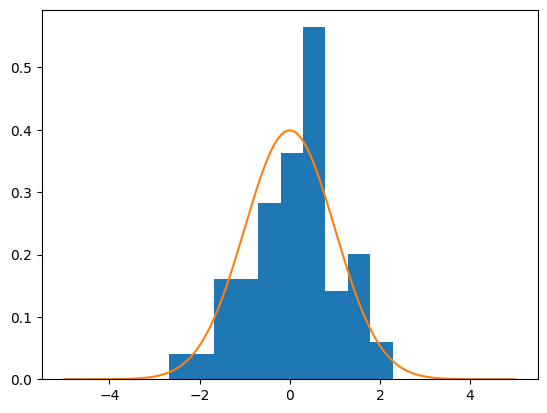

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters

    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...

    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1   # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2,
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

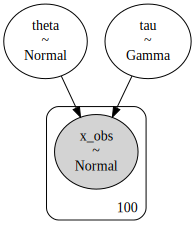

In [6]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [7]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Output()

Output()

## `idata` and `arviz as az`

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    tau      (chain, draw) float64 160kB 1.006 1.004 1.122 ... 1.209 1.189 1.049
    theta    (chain, draw) float64 160kB 0.01362 -0.03765 ... 0.07191 0.1219
Attributes:
    created_at:                 2025-02-12T19:02:51.046460+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0
    sampling_time:              14.349403619766235
    tuning_steps:               100

In [10]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[ 0.01361936, -0.03764743,  0.16140524, ...,  0.07295545,
         0.08957605,  0.18277639],
       [ 0.15782218,  0.15782218,  0.16364928, ...,  0.01467462,
         0.07190986,  0.12185868]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [11]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.00592397, 1.00377987, 1.12206859, ..., 1.08399271, 1.09543921,
        0.82412923],
       [1.00081218, 1.00081218, 1.14831969, ..., 1.20850992, 1.18866997,
        1.04885599]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

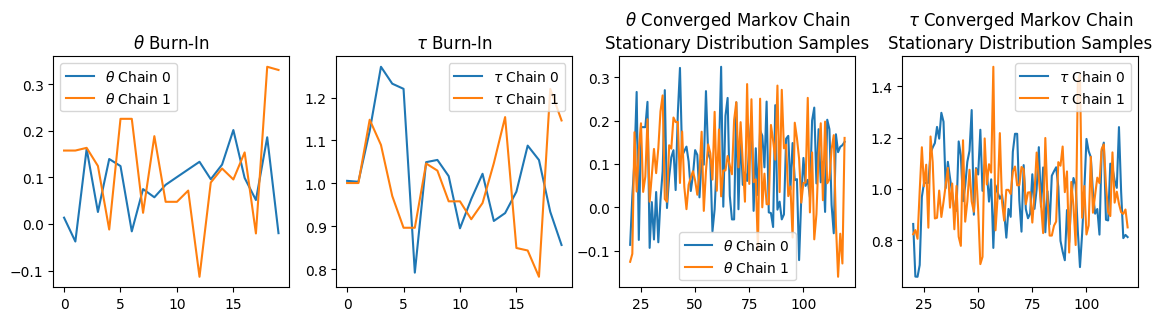

In [12]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend();

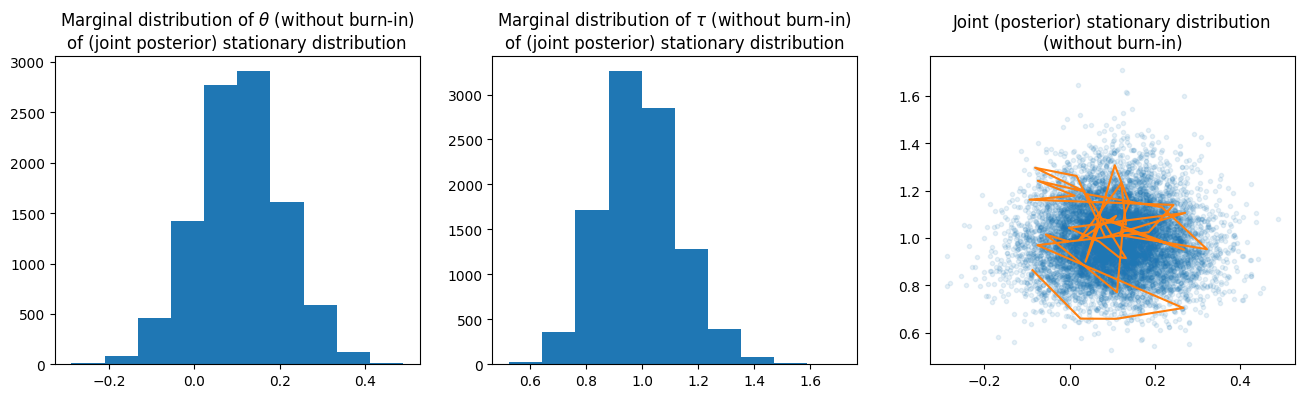

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [14]:
import arviz as az

In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

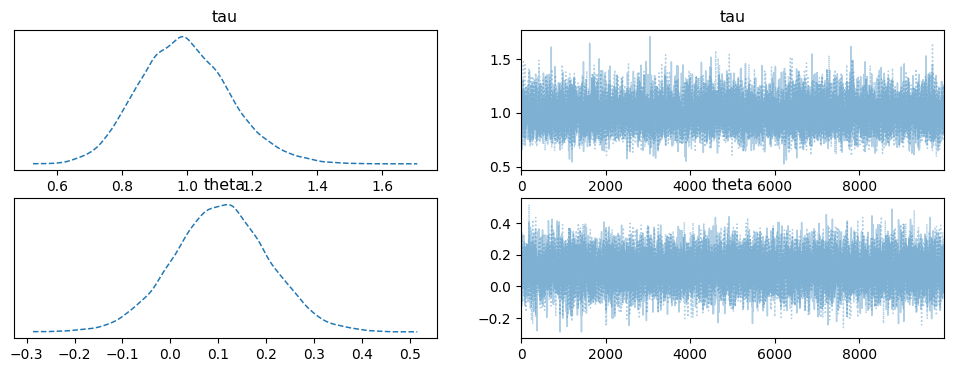

In [16]:
az.plot_trace(idata, combined=True);

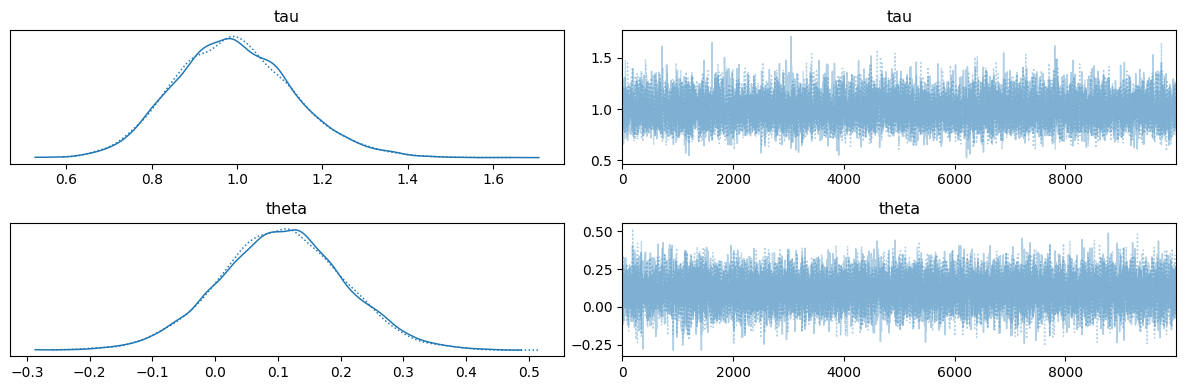

In [17]:
az.plot_trace(idata)
plt.tight_layout()

In [18]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

Output()

Output()

In [19]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

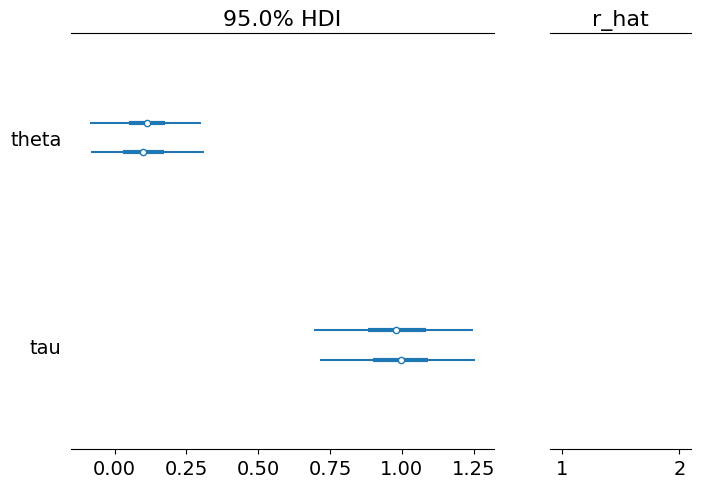

In [20]:
az.plot_forest(idata, var_names=["theta", "tau"],
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [21]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

In [22]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [23]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.10543, 0.99244)

In [24]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.10135, 0.14184)

### `hdi_3%` and `hdi_97%`

In [25]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

In [26]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.05852,  0.26727])

In [27]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.09629,  0.2982 ])

In [28]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.08338,  0.29341])

In [29]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.10956,  0.28065])

In [30]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.72434, 1.25655])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [31]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

In [32]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.0022542442343607225

In [33]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.004932407056353942

In [34]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


1.0905316238459413e-07

In [35]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the
#  standard deviation (SD) of a single variable
#  without assuming normality using moments of moments
#  and first order Taylor series approximation
#  (Kenney and Keeping, 1951, p. 141)."

0.0032592894157166892

In [36]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.006870888337273298

In [37]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [38]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1419.7745494579772

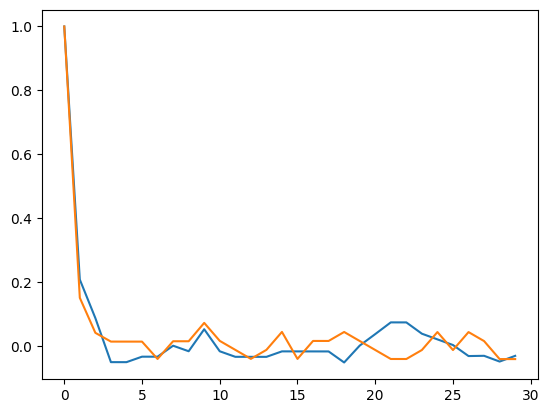

In [39]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k],
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [40]:
autocorrelations[:,:10]

array([[ 1.        ,  0.20897167,  0.08853736, -0.04911161, -0.04918146,
        -0.03205062, -0.03211962,  0.00221753, -0.01505376,  0.05369978],
       [ 1.        ,  0.15195246,  0.04248904,  0.01509248,  0.01505329,
         0.01501402, -0.03920196,  0.01618843,  0.01614951,  0.07357216]])

In [41]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1206.4484265558663

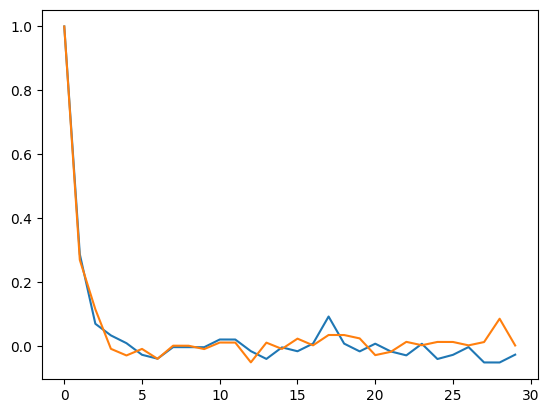

In [42]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k],
                    tau_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [43]:
autocorrelations[:,:20]

array([[ 1.00000000e+00,  2.86670378e-01,  6.89508948e-02,
         3.25789001e-02,  8.29336409e-03, -2.80924827e-02,
        -4.02930403e-02, -4.10565045e-03, -4.20777890e-03,
        -4.31013431e-03,  1.97899987e-02,  1.96896645e-02,
        -1.67224080e-02, -4.10370879e-02, -4.82534226e-03,
        -1.70366546e-02,  7.07579095e-03,  9.17434583e-02,
         6.86967354e-03, -1.74589455e-02],
       [ 1.00000000e+00,  2.68848572e-01,  1.14271267e-01,
        -9.44292917e-03, -3.01707643e-02, -9.69204962e-03,
        -4.07297984e-02,  3.63236332e-04,  2.38968487e-04,
        -1.01936799e-02,  1.02989722e-02,  1.01751460e-02,
        -5.18207721e-02,  9.92664730e-03, -9.72610168e-03,
         2.24575844e-02,  1.53270665e-03,  3.39082292e-02,
         3.37874283e-02,  2.32181730e-02]])

In [44]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

#### Reminder

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2248.378950468802

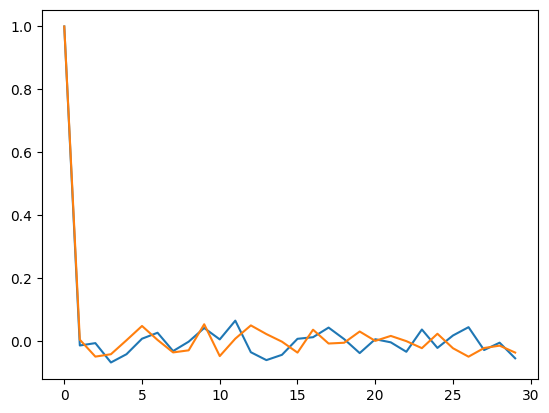

In [45]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k],
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [46]:
autocorrelations[:,:10]

array([[ 1.        , -0.01368132, -0.00617583, -0.0676769 , -0.04147073,
         0.00785678,  0.02681949, -0.03137289, -0.00161678,  0.04193396],
       [ 1.        ,  0.00474075, -0.04902579, -0.04147238,  0.00286176,
         0.04832414,  0.0039196 , -0.03570311, -0.02906927,  0.05375851]])

902.8043116389123

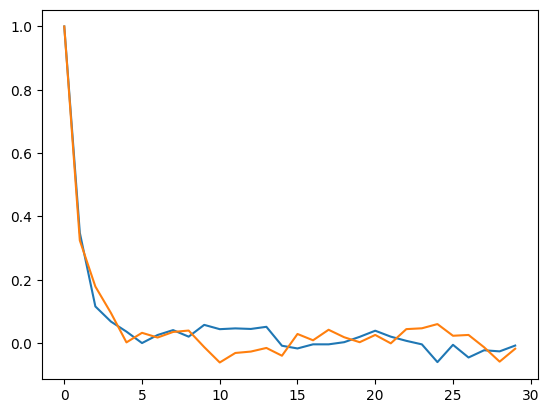

In [47]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k],
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [48]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  3.48356234e-01,  1.15703387e-01,
         6.79555984e-02,  3.61325647e-02,  4.86247023e-05,
         2.54384965e-02,  4.09884964e-02,  2.02284990e-02,
         5.75147602e-02],
       [ 1.00000000e+00,  3.24250114e-01,  1.78560085e-01,
         9.52717045e-02,  2.20637647e-03,  3.23971652e-02,
         1.75217421e-02,  3.51507648e-02,  3.95914359e-02,
        -1.26449894e-02]])

In [49]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

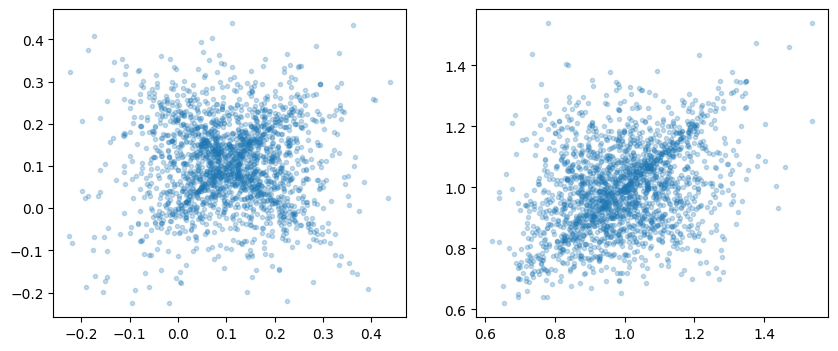

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $

In [51]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99244  0.14184  0.71555  1.23945    0.00494   0.0035   826.95071   
theta  0.10543  0.10135 -0.07948  0.29462    0.00226   0.0017  2021.36886   

         ess_tail    r_hat  
tau    1035.02563  1.00266  
theta  1351.78352  1.00136

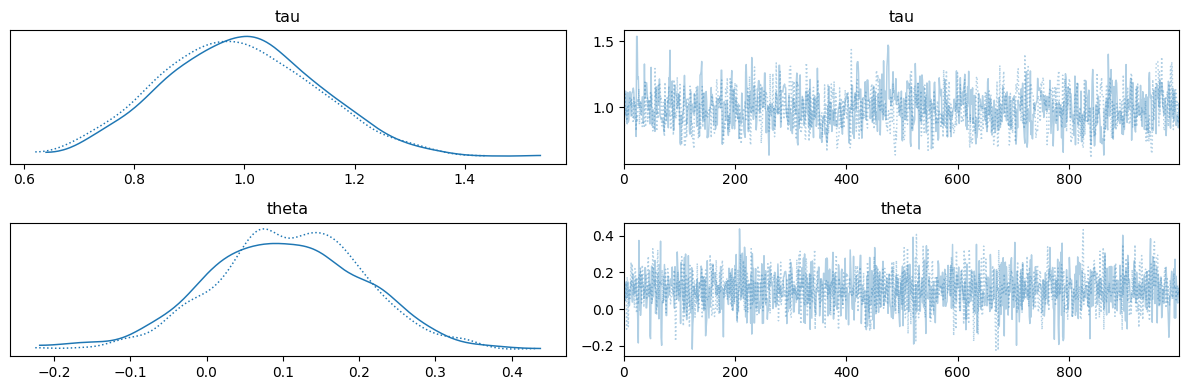

In [52]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


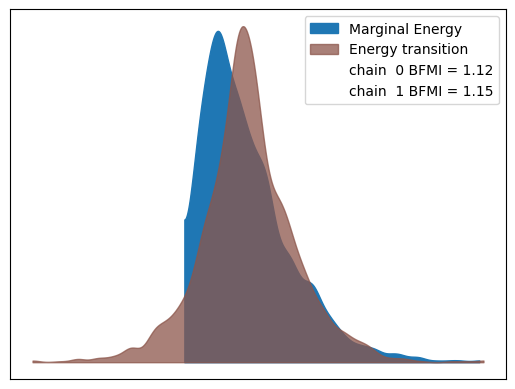

In [53]:
az.plot_energy(idata);

## Part D: Samplers


In [54]:
pymc.sample?

INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:HamiltonianMC: [theta, tau]


Output()

Output()

Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.00  0.14    0.73     1.26        0.0      0.0   1907.43   2071.66   
theta  0.11  0.10   -0.09     0.29        0.0      0.0   2172.47   2187.15   

       r_hat  
tau      1.0  
theta    1.0

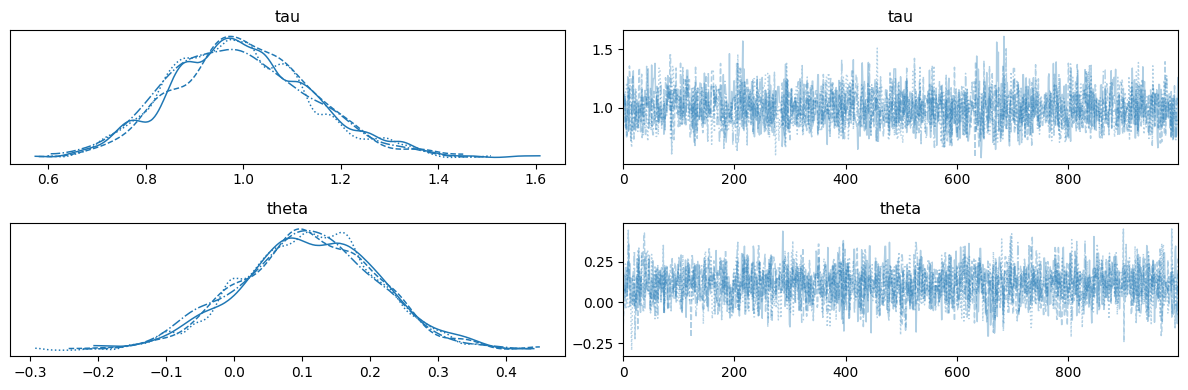

In [55]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)

display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()

In [56]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.28428428, 0.33933934, 0.32132132, 0.31931932])

In [57]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.28428428, 0.33933934, 0.32132132, 0.31931932])

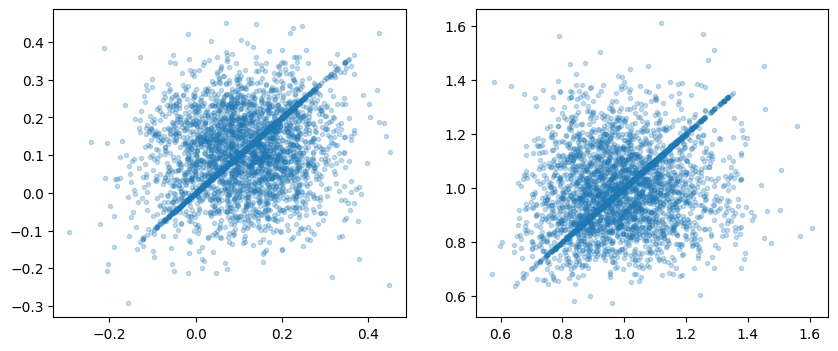

In [58]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1],
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1],
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [theta, tau]


Output()

Output()

Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.99  0.14    0.75     1.27        0.0      0.0   4043.47   3023.96   
theta  0.11  0.10   -0.07     0.31        0.0      0.0   4121.18   2700.56   

       r_hat  
tau      1.0  
theta    1.0

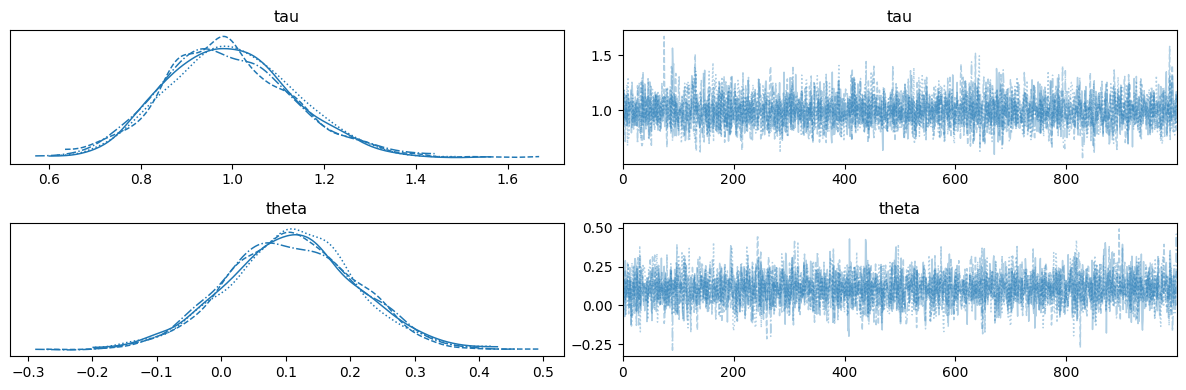

In [59]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)

display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()

In [60]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

0         1         2         3         4         5         6    \
0  0.920697  0.890902  0.995887  0.937031  0.821096  0.920098  1.000000   
1  0.985462  0.818206  1.000000  1.000000  0.856837  0.999490  0.950631   
2  0.957866  0.992769  0.996169  0.846336  1.000000  0.739769  1.000000   
3  0.963325  0.904069  0.968628  0.885685  0.979955  0.982287  0.926881   

        7         8         9    ...       990       991       992       993  \
0  0.906040  0.972266  0.795439  ...  0.803556  0.933248  1.000000  0.947855   
1  0.855482  0.939542  0.589069  ...  0.943257  0.944500  0.995522  0.926217   
2  0.758845  0.955576  0.892724  ...  0.576024  0.636353  0.996552  0.935526   
3  0.757323  0.989578  0.969040  ...  1.000000  0.473483  1.000000  1.000000   

        994       995       996       997       998       999  
0  0.799864  0.976808  0.958957  0.921706  0.976189  1.000000  
1  0.800348  0.973556  1.000000  0.971289  0.523119  0.957720  
2  0.983582  0.866787  0.966194  0.800350  0.925619  0.849697  
3  0.907894  1.000000  0.890406  0.964854  0.354520  0.998196  

[4 rows x 1000 columns]

array([0.0978598 , 0.09101133, 0.11101629, 0.09028034])

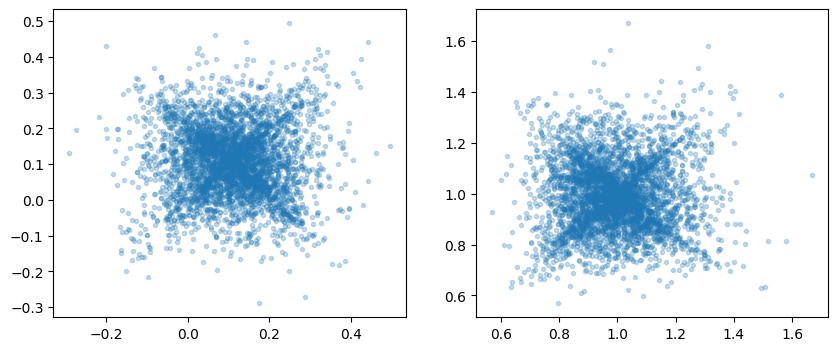

In [61]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1],
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1],
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>Slice: [theta]
INFO:pymc.sampling.mcmc:>Slice: [tau]


Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.99  0.14    0.73     1.24        0.0      0.0   1875.91   1406.67   
theta  0.11  0.10   -0.09     0.29        0.0      0.0   1762.89   1110.24   

       r_hat  
tau      1.0  
theta    1.0

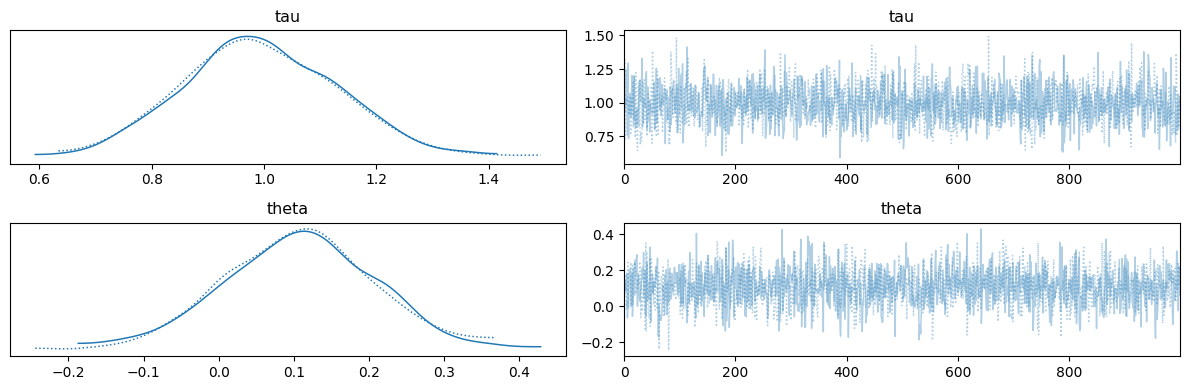

In [62]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()

In [63]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0.])

In [64]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0.])

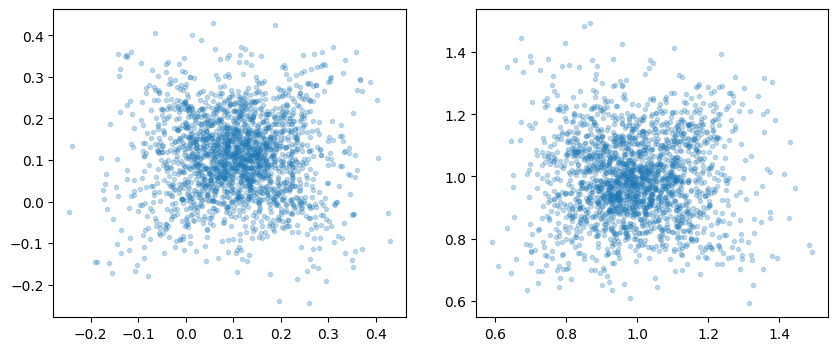

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1],
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1],
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>Metropolis: [theta]
INFO:pymc.sampling.mcmc:>Metropolis: [tau]


Output()

Output()

Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 2 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.99  0.14    0.75     1.25       0.01      0.0    503.82    425.61   
theta  0.11  0.11   -0.07     0.32       0.01      0.0    445.87    376.73   

       r_hat  
tau     1.01  
theta   1.01

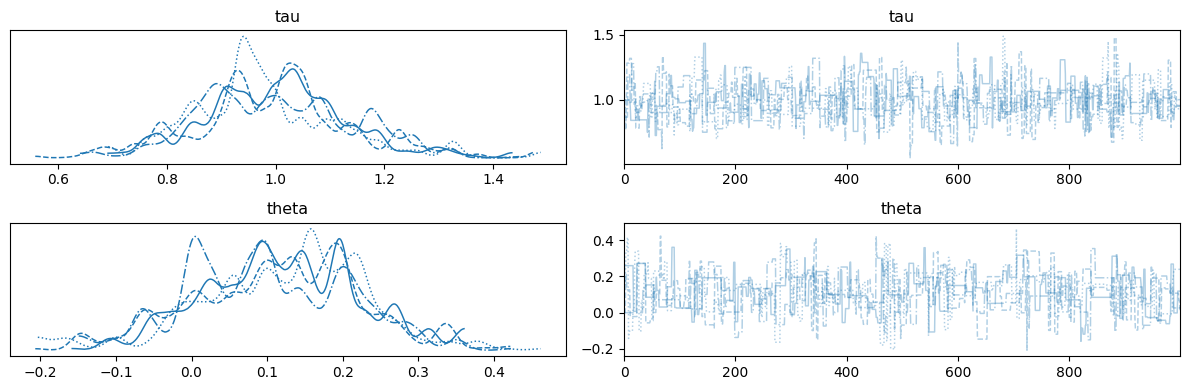

In [66]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()

In [67]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.86986987, 0.85885886, 0.86786787, 0.87287287])

In [68]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.81981982, 0.81881882, 0.84184184, 0.84884885])

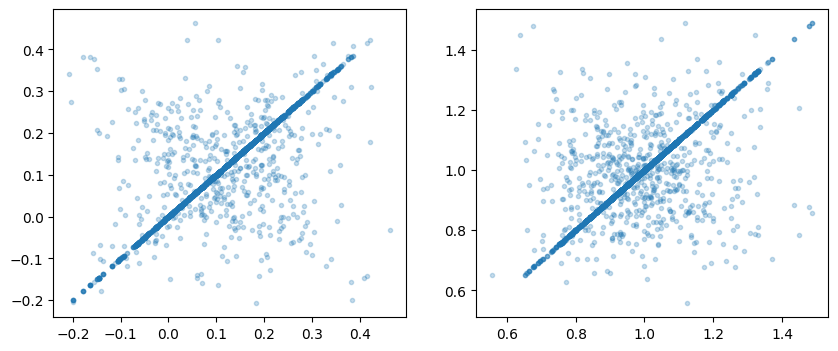

In [69]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1],
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1],
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>Metropolis: [theta]
INFO:pymc.sampling.mcmc:>Metropolis: [tau]


Output()

Output()

Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 2 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.99  0.14    0.73     1.23       0.01     0.01    281.37    529.67   
theta  0.12  0.11   -0.09     0.31       0.00     0.00    498.48    672.44   

       r_hat  
tau     1.01  
theta   1.03

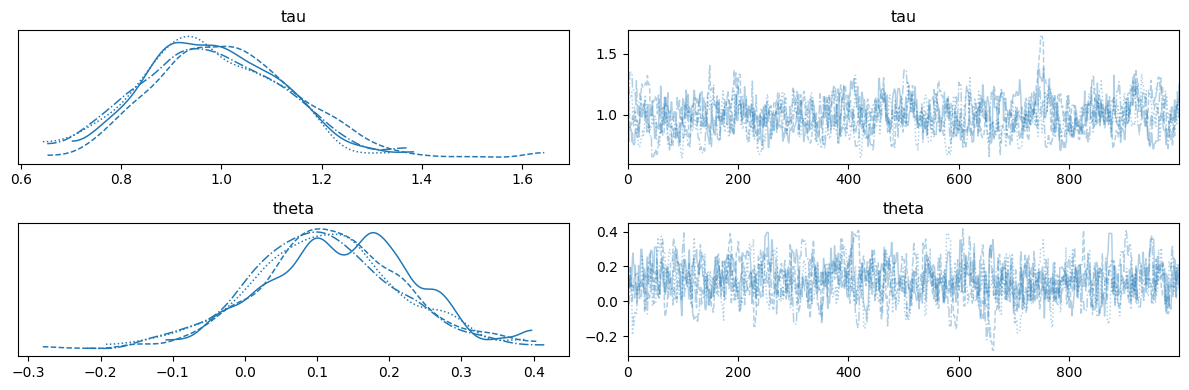

In [70]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()

In [71]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.2952953 , 0.34734735, 0.30930931, 0.29429429])

In [72]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.23423423, 0.22022022, 0.23923924, 0.23623624])

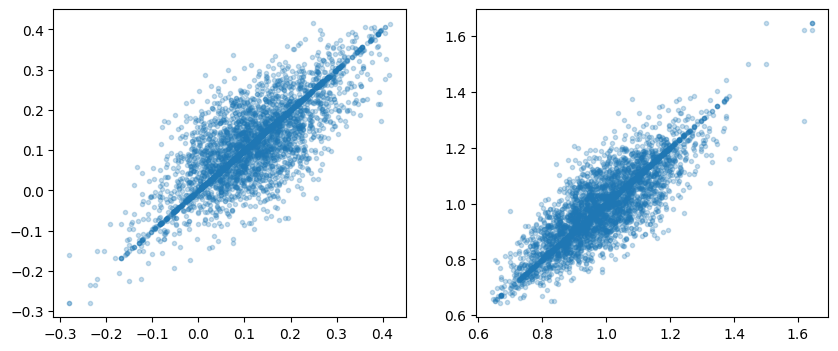

In [73]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1],
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1],
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/dimensionality.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/pytensor_pymc.png" width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/data_container.png)|


#### How to

- Prior and Posterior Predictive Checks
- Model Comparison
- Updating Priors
- Automatic marginalization of discrete variables
- How to debug a model
- How to wrap a JAX function for use in PyMC
- Splines
- Bayesian copula estimation: Describing correlated joint distributions
- Using ModelBuilder class for deploying PyMC models
- Using a "black box" likelihood function
- LKJ Cholesky Covariance Priors for Multivariate Normal Models
- Bayesian Missing Data Imputation
- Profiling


| | | | |
|-|-|-|-|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/model_comparison.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/posterior_predictive.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/updating_priors.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/marginalizing-models.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/howto_debugging.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/wrapping_jax_function.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/spline.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/copula-estimation.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/model_builder.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/blackbox_external_likelihood_numpy.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/LKJ.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/Missing_Data_Imputation.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/profiling.png" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|


#### Generalized Linear Models

- GLM: Robust Linear Regression
- GLM-ordinal-features
- Out-Of-Sample Predictions
- Bayesian regression with truncated or censored data
- Binomial regression
- GLM: Negative Binomial Regression
- Hierarchical Binomial Model: Rat Tumor Example
- A Primer on Bayesian Methods for Multilevel Modeling
- GLM-missing-values-in-covariates
- Regression Models with Ordered Categorical Outcomes
- GLM: Poisson Regression
- Discrete Choice and Random Utility Models
- GLM: Model Selection
- GLM: Robust Regression using Custom Likelihood for Outlier Classification
- Rolling Regression

| | | | |
|-|-|-|-|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-robust.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-ordinal-features.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-out-of-sample-predictions.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-truncated-censored-regression.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-binomial-regression.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-negative-binomial-regression.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-hierarchical-binomial-model.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/multilevel_modeling.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-missing-values-in-covariates.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-ordinal-regression.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-poisson-regression.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-discrete-choice_models.png" width="500"/>|
|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-model-selection.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-robust-with-outlier-detection.png" width="500"/>|<img src="https://www.pymc.io/projects/examples/en/latest/_images/GLM-rolling-regression.png" width="500"/>|<img src="" width="500"/>|


#### Case Studies

- Confirmatory Factor Analysis and Structural Equation Models in Psychometrics
- Hierarchical Partial Pooling
- NBA Foul Analysis with Item Response Theory
- Bayesian Estimation Supersedes the T-Test
- A Hierarchical model for Rugby prediction
- Estimating parameters of a distribution from awkwardly binned data
- Factor analysis
- Probabilistic Matrix Factorization for Making Personalized Recommendations
- Reliability Statistics and Predictive Calibration
- Generalized Extreme Value Distribution
- Model building and expansion for golf putting
- Fitting a Reinforcement Learning Model to Behavioral Data with PyMC

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|


#### Causal Inference

- Simpson's paradox
- Interrupted time series analysis
- Regression discontinuity design analysis
- Interventional distributions and graph mutation with the do-operator
- Bayesian Non-parametric Causal Inference
- Bayesian mediation analysis
- Counterfactual inference: calculating excess deaths due to COVID-19
- Introduction to Bayesian A/B Testing
- Difference in differences
- Bayesian moderation analysis


| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Gaussian Processes

- Mean and Covariance Functions
- Student-t Process
- Heteroskedastic Gaussian Processes
- Gaussian Processes: Latent Variable Implementation
- Sparse Approximations
- Gaussian Processes using numpy kernel
- Kronecker Structured Covariances
- Example: Mauna Loa CO_2 continued
- Gaussian Process for CO2 at Mauna Loa
- Gaussian Processes: HSGP Reference & First Steps
- Baby Births Modelling with HSGPs
- Marginal Likelihood Implementation
- Multi-output Gaussian Processes: Coregionalization models using Hamadard product
- GP-Circular
- Modeling spatial point patterns with a marked log-Gaussian Cox process
- Gaussian Processes: HSGP Advanced Usage
- Gaussian Process (GP) smoothing


| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Time Series

- Longitudinal Models of Change
- Forecasting with Structural AR Timeseries
- Analysis of An AR(1) Model in PyMC
- Stochastic Volatility model
- Time Series Models Derived From a Generative Graph
- Bayesian Vector Autoregressive Models
- Air passengers - Prophet-like model
- Multivariate Gaussian Random Walk
- Inferring parameters of SDEs using a Euler-Maruyama scheme

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Spatial Analysis

- The Besag-York-Mollie Model for Spatial Data
- The prevalence of malaria in the Gambia
- Conditional Autoregressive (CAR) Models for Spatial Data

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Diagnostics and Model Criticism

- Bayes Factors and Marginal Likelihood
- Diagnosing Biased Inference with Divergences
- Sampler Statistics
- Model Averaging

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Bayesian Additive Regression Trees

- Categorical regression
- Bayesian Additive Regression Trees: Introduction
- Modeling Heteroscedasticity with BART
- Quantile Regression with BART

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Mixture Models

- Gaussian Mixture Model
- Dependent density regression
- Dirichlet process mixtures for density estimation
- Marginalized Gaussian Mixture Model
- Dirichlet mixtures of multinomials

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Survival Analysis

- Reparameterizing the Weibull Accelerated Failure Time Model
- Bayesian Survival Analysis
- Censored Data Models
- Frailty and Survival Regression Models
- Bayesian Parametric Survival Analysis

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### ODE models

- ODE Lotka-Volterra With Bayesian Inference in Multiple Ways
- Lotka-Volterra with manual gradients
- pymc3.ode: Shapes and benchmarking
- GSoC 2019: Introduction of pymc3.ode API

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### MCMC

- Lasso regression with block updating
- Approximate Bayesian Computation
- DEMetropolis and DEMetropolis(Z) Algorithm Comparisons
- Faster Sampling with JAX and Numba
- Sequential Monte Carlo

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

#### Variational Inference

- Variational Inference: Bayesian Neural Networks
- Pathfinder Variational Inference
- Empirical Approximation overview
- Introduction to Variational Inference with PyMC
- GLM: Mini-batch ADVI on hierarchical regression model

| | | | |
|-|-|-|-|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|
|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|<img src="" width="500"/>|

### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### **Solution**

Completed with the help of ChatGPT.

#### Common Setup

First, we simulate some data. Here we assume

$$
x_i\sim \mathcal{N}(\theta,\;1/	\tau)
$$

with true parameters chosen for illustration.

In [76]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

np.random.seed(123)
n = 30
theta_true = 2.0
tau_true = 1.0  # so variance = 1/tau_true = 1
# simulate data; note: standard deviation = sqrt(1/tau_true)=1.
x = np.random.normal(loc=theta_true, scale=1/np.sqrt(tau_true), size=n)

# For later plotting of x's sample mean, etc.
x_mean = np.mean(x)

#### **Case 1. Conjugate‐like Priors**

Use:
- $ \theta \sim \mathcal{N}(\theta_0,\, \sigma_0^2) $ with, say, $\theta_0=0,\ \sigma_0^2=1/\tau_0$ (here we set $\tau_0=1$)
- $ \tau \sim \text{Gamma}(\alpha, \beta) $ (with shape and rate parameters)

In PyMC the Gamma is parameterized by alpha and beta (beta is the rate). We then run the sampler and check diagnostics.

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [theta, tau]


Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


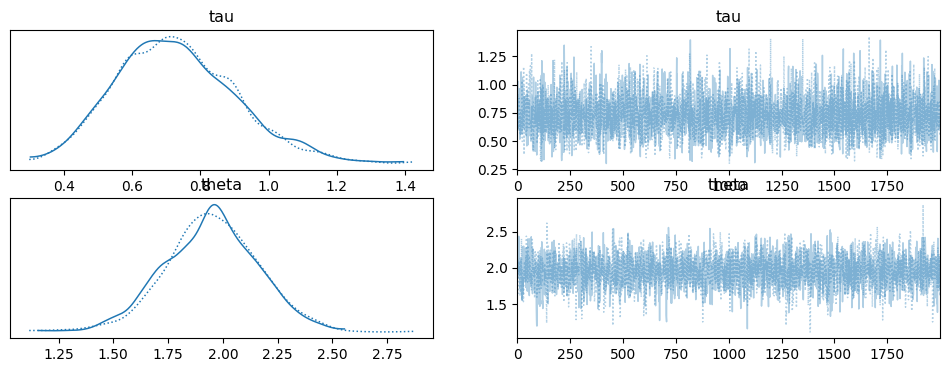

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.73  0.18    0.42     1.09        0.0      0.0   3542.70   2666.99   
theta  1.95  0.21    1.57     2.37        0.0      0.0   2904.22   2342.07   

       r_hat  
tau      1.0  
theta    1.0  


In [77]:
with pm.Model() as model1:
    # Hyperparameters for the priors:
    theta0 = 0.0
    tau0 = 1.0  # precision for the theta prior (i.e. variance = 1/tau0)
    alpha_prior = 2.0
    beta_prior = 2.0

    # Priors
    theta = pm.Normal("theta", mu=theta0, sigma=1/np.sqrt(tau0))
    tau = pm.Gamma("tau", alpha=alpha_prior, beta=beta_prior)

    # Likelihood: note that variance=1/tau, so std = 1/sqrt(tau)
    likelihood = pm.Normal("x", mu=theta, sigma=1/pm.math.sqrt(tau), observed=x)

    # Inference
    trace1 = pm.sample(2000, tune=2000, return_inferencedata=True, target_accept=0.9)

# Diagnostics for Model 1:
az.plot_trace(trace1)
plt.show()
print(az.summary(trace1, round_to=2))

*Discussion (Case 1):*  
Because our priors here are "conjugate‐like" (a normal prior on θ and gamma on τ for a normal likelihood), the full conditionals can be derived analytically. Our PyMC sampling confirms that the posterior for θ is approximately normal and that for τ is gamma‐like. The summary (including R̂ values near 1 and high effective sample sizes) and trace plots indicate good convergence.

---

#### **Case 2. Non‐Normal for θ and Non‐Gamma for τ**

Here we choose, for instance, a Cauchy prior for θ and an Exponential prior for τ. These choices break conjugacy.

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [theta, tau]


Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 11 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


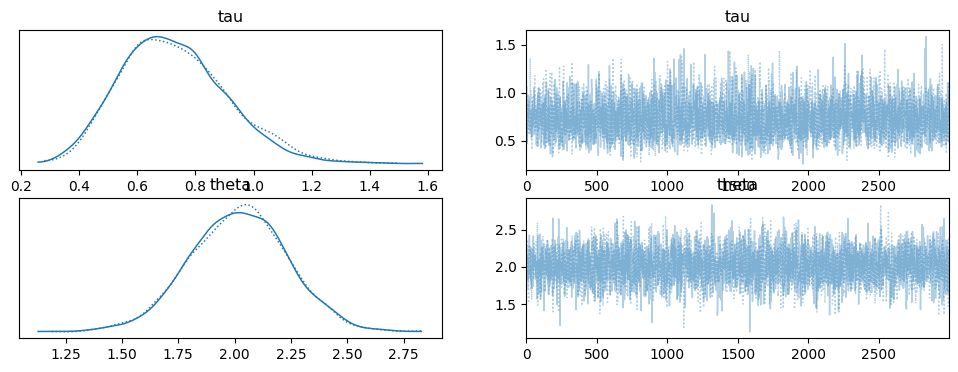

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.73  0.18    0.42     1.09        0.0      0.0   3693.17   3740.75   
theta  2.02  0.22    1.62     2.43        0.0      0.0   3727.06   3585.30   

       r_hat  
tau      1.0  
theta    1.0  


In [78]:
with pm.Model() as model2:
    # Priors: non-conjugate choices.
    theta = pm.Cauchy("theta", alpha=0, beta=2)  # Cauchy prior centered at 0 with scale=2
    tau = pm.Exponential("tau", lam=1)           # Exponential prior for tau, rate=1

    # Likelihood remains Normal.
    likelihood = pm.Normal("x", mu=theta, sigma=1/pm.math.sqrt(tau), observed=x)

    trace2 = pm.sample(3000, tune=3000, return_inferencedata=True, target_accept=0.95)

# Diagnostics for Model 2:
az.plot_trace(trace2)
plt.show()
print(az.summary(trace2, round_to=2))

*Discussion (Case 2):*  
The Cauchy prior is heavy tailed and non-normal, and the Exponential for τ is not the conjugate gamma. In this model the full conditionals cannot be derived in closed form, so we rely on Metropolis–within–Gibbs (implemented automatically in PyMC’s NUTS sampler). Our diagnostic plots (which include sometimes thicker tails in the θ trace) and summary statistics (R̂ ≈ 1, decent ESS) suggest that the sampler has mixed well despite the nonconjugacy. In addition, we might check posterior predictive distributions using `az.plot_ppc`.

---

### **Case 3. Yet Another Non-Conjugate Pair**

Now we choose different non-normal priors. For example, let’s use a Laplace (double exponential) prior for θ and a LogNormal prior for τ.

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [theta, tau]


Output()

Output()

INFO:pymc.sampling.mcmc:Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 12 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


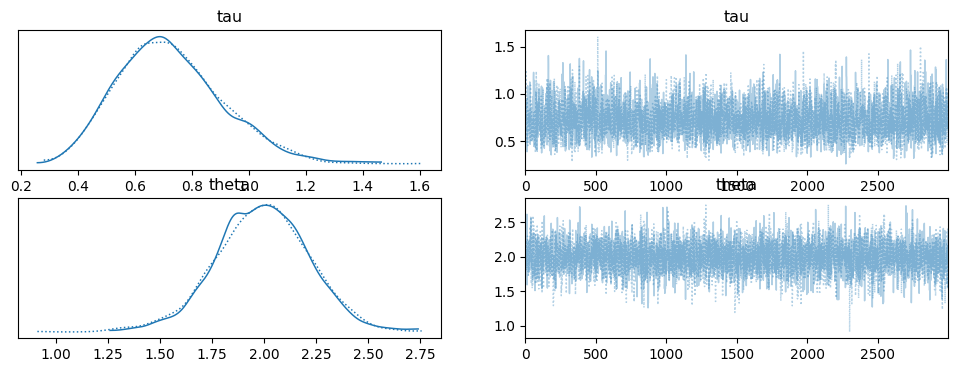

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    0.72  0.18    0.39     1.07        0.0      0.0   3644.09   3466.34   
theta  1.99  0.22    1.59     2.43        0.0      0.0   3866.91   3133.26   

       r_hat  
tau      1.0  
theta    1.0  


In [79]:
with pm.Model() as model3:
    # Priors: yet another non-conjugate choice.
    theta = pm.Laplace("theta", mu=0, b=1)   # Laplace prior centered at 0, scale=1.
    tau = pm.LogNormal("tau", mu=0, sigma=1)   # LogNormal prior for tau

    # Likelihood
    likelihood = pm.Normal("x", mu=theta, sigma=1/pm.math.sqrt(tau), observed=x)

    trace3 = pm.sample(3000, tune=3000, return_inferencedata=True, target_accept=0.95)

# Diagnostics for Model 3:
az.plot_trace(trace3)
plt.show()
print(az.summary(trace3, round_to=2))

*Discussion (Case 3):*  
Here the Laplace prior for θ is more peaked at zero than a normal and has heavier tails, while the LogNormal prior for τ forces τ to be positive with a skewed distribution. As before, PyMC’s adaptive sampler (NUTS) does not require closed‐form full conditionals; instead it uses gradient information from the joint density. The diagnostic plots and summary statistics again show that our chains have converged (R̂ near 1, good ESS) though note that the posterior for τ may be slightly skewed.

---

### **Overall Diagnostics and Comments**

For each model we:
- **Checked trace plots** to ensure good mixing.
- **Examined the summary statistics** (R̂, effective sample size) using ArviZ’s `az.summary`.
- (Optionally) one can generate posterior predictive checks using  

```python
ppc = pm.sample_posterior_predictive(traceX, model=modelX)
az.plot_ppc(az.from_pymc(posterior_predictive=ppc, model=modelX))
```

for further confirmation that the model captures the data.

Because in non-conjugate settings (Cases 2 and 3) we do not have closed‐form full conditionals, we rely on PyMC’s general-purpose NUTS (or Metropolis–within–Gibbs if explicitly coded) to perform inference. This flexibility shows that deriving full conditional distributions is unnecessary as long as the joint density can be evaluated (and its gradients computed).

---

### Concluding Remarks

1. **Case 1** (Normal/Gamma priors) benefits from conjugacy—both full conditionals are of standard form. Diagnostic plots show rapid convergence.
2. **Case 2** (Cauchy/Exponential) and **Case 3** (Laplace/LogNormal) use non-conjugate priors; here the sampling relies on general MCMC (e.g. NUTS) and full conditionals are not derived explicitly. Nonetheless, diagnostics (trace plots, R̂, ESS) indicate good performance.
3. These examples also illustrate how the hyperparameters (for example, the scale in the Normal prior or the rate in the Gamma/Exponential) influence the degree to which the prior "contributes" information relative to the likelihood. One can interpret these hyperparameters as if they were adding an equivalent number of pseudo–observations.

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [74]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):

    # find interval of grid points where f(x_grid) > y
    # then extend the enterval so endpoints f(a)<y and f(b)<y
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid

    x_ = a + stats.uniform().rvs()*(b-a)
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f"
    elif x_ < x:  # or if "x_ was above f on the left side of the interval"
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):

    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)

    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


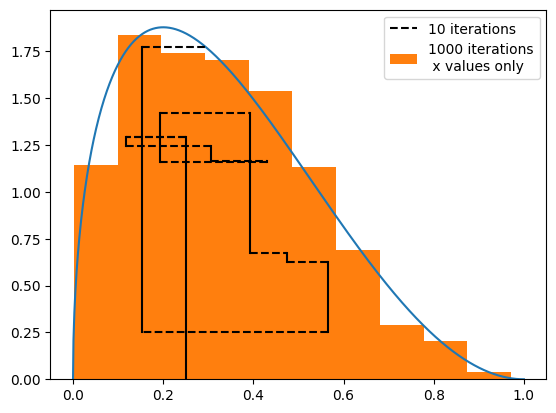

In [75]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))

m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):

    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')

    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')

plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

### **Solution**

Completed with the help of ChatGPT.